# Inference with original cnn_virus trained model

- Inference only, no training.
- Experiments with cov_reads files
- Trying locally

# Imports and setup environment

### Install and import packages

In [ ]:
try:
    from ecutilities.ipython import nb_setup
    print('`ecutilities` already installed')
except ModuleNotFoundError as e:
    print('will install ecutilities')
    !pip install -qqU ecutilities
    from ecutilities.ipython import nb_setup

nb_setup()

`ecutilities` already installed
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


In [ ]:
# import configparser
import numpy as np
import pandas as pd
# import psutil
# import os
# import shutil
# import sys
import tensorflow as tf

from pathlib import Path
from pprint import pprint
from tensorflow.python.client import device_lib

In [ ]:
print(f"Tensorflow version: {tf.__version__}\n")

devices = device_lib.list_local_devices()
print('\nDevices:')
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':', 1) for item in name.split(', ')]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', ' ')
    print(f"  - {t}  {d.name} {dev:25s}")

Tensorflow version: 2.8.2


Devices:
  - CPU  /device:CPU:0                          
  - GPU  /device:GPU:0  NVIDIA GeForce GTX 1050 


2023-02-03 16:47:03.267662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:47:03.268415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:47:03.269173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:47:04.118487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:47:04.118515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1609] Could not ident

## Install and import custom code, mount gdrive

In [ ]:
p = Path().absolute()
p.absolute()

PosixPath('/home/vtec/projects/bio/metagentools/nbs/cnn_virus/02_inference_original_model')

In [ ]:
# MODIFY AFTER INSTALLING ECUTILITIES >= 1.2.3

from ecutilities.core import validate_path

def safe_path(
    path:str|Path, # path to validate
)-> Path:          # validated path as a  pathlib.Path
    """"""
    validate_path(path, path_type='dir', raise_error=True)
    if isinstance(path, str): 
        path = Path(path)
    return path

def nbs_root_dir(
    path:str|Path|None = None, # path from where to seek for notebook parent directory
    pattern:str = 'nbs',       # pattern to identify the nbs directory
)-> Path:                      # path of the parent directory
    """Climb the directory tree up to the notebook directory and return its path"""    
    if path is None: path = Path()
    path = safe_path(path).absolute()
    tree = [path.name] + [p.name for p in path.parents]
    mask = [True if n.startswith(pattern) else False for n in tree]
    nbs = Path(f"{'../' * (mask.index(True))}").resolve()
    return nbs
    
nbs = nbs_root_dir(Path())
nbs

PosixPath('/home/vtec/projects/bio/metagentools/nbs')

In [ ]:
try:
    from google.colab import drive
    ON_COLAB = True
    print('Running on colab')
    print('Installing custom project code')   
    !pip install -U git+https://github.com/vtecftwy/metagenomics.git@refactor_cnn_virus
    drive.mount('/content/gdrive')
    
    p2drive = Path('/content/gdrive/MyDrive/Metagenonics')
    assert p2drive.is_dir()
    p2data =  p2drive / 'CNN_Virus_data'
    assert p2data.is_dir()

except ModuleNotFoundError as e:
#     print(e)
    ON_COLAB = False
    print('Running locally')
    print('Make sure you have installed the custom project code in your environment')
    p2data = nbs_root_dir().parent / 'data/'
    assert p2data.is_dir()
    print(p2data.absolute())

Running locally
Make sure you have installed the custom project code in your environment
/home/vtec/projects/bio/metagentools/data


#  Setup paths

This assumes that the shared gdrive directory is accessible through a shortcut called `Metagenomics` under the root of gdrive.

In [ ]:
# p2drive = Path('/content/gdrive/MyDrive/Metagenonics')
# assert p2drive.is_dir()

# p2data =  p2drive / 'CNN_Virus_data'
# assert p2data.is_dir()

In [ ]:
# path for original trained model
p2saved = p2data / 'saved/cnn_virus_original/pretrained_model.h5'
p2simreads = p2data / 'cov_simreads/single_10seq_50bp'
assert p2saved.is_file()
assert p2simreads.is_dir()

#path for the learning weights file
# filepath_weights=p2data / "weight_of_classes"
# assert filepath_weights.is_file()

# Create test dataset

In [ ]:
p2fastq = p2simreads / f"{p2simreads.stem}.fq"
p2aln = p2simreads / f"{p2simreads.stem}.aln"
assert p2fastq.is_file()
assert p2aln.is_file()

In [ ]:
from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader

In [ ]:
fastq = FastqFileReader(p2fastq)
aln = AlnFileReader(p2aln)

Exploring the simreads

In [ ]:
for i, (k,v) in enumerate(fastq.parse_fastq(add_seq=True).items()):
    print(k)
    print()
    pprint(v)
    if i+1 >= 3: break

2591237:ncbi:1-60400

{'read_nbr': '60400',
 'readid': '2591237:ncbi:1-60400',
 'seq_nbr': '1',
 'seqid': '2591237',
 'sequence': 'ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG',
 'source': 'ncbi'}
2591237:ncbi:1-60399

{'read_nbr': '60399',
 'readid': '2591237:ncbi:1-60399',
 'seq_nbr': '1',
 'seqid': '2591237',
 'sequence': 'GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC',
 'source': 'ncbi'}
2591237:ncbi:1-60398

{'read_nbr': '60398',
 'readid': '2591237:ncbi:1-60398',
 'seq_nbr': '1',
 'seqid': '2591237',
 'sequence': 'ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC',
 'source': 'ncbi'}


Exploring alignment header (reference sequences)

In [ ]:
pprint(aln.ref_sequences)

{'11120': {'refseq_accession': 'MN987231',
           'refseq_length': '27617',
           'refseq_nbr': '5',
           'refseqid': '11120',
           'source': 'ncbi',
           'species': 'Infectious bronchitis virus  scientific name'},
 '11128': {'refseq_accession': 'LC494191',
           'refseq_length': '30942',
           'refseq_nbr': '2',
           'refseqid': '11128',
           'source': 'ncbi',
           'species': 'Bovine coronavirus  scientific name'},
 '1699095': {'refseq_accession': 'KT368904',
             'refseq_length': '27395',
             'refseq_nbr': '10',
             'refseqid': '1699095',
             'source': 'ncbi',
             'species': 'Camel alphacoronavirus  scientific name'},
 '2591237': {'refseq_accession': 'MK211378',
             'refseq_length': '30213',
             'refseq_nbr': '1',
             'refseqid': '2591237',
             'source': 'ncbi',
             'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific name'},
 '277944': {

Exploring the read metadata

In [ ]:
for i, (k,v) in enumerate(aln.parse_aln(add_ref_seq_aligned=True).items()):
    print(k)
    pprint(v)
    print()
    if i+1>=3: break

2591237:ncbi:1-60400
{'aln_start_pos': '14770',
 'read_nbr': '60400',
 'readid': '2591237:ncbi:1-60400',
 'ref_seq_aligned': 'ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG',
 'ref_seq_strand': '+',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}

2591237:ncbi:1-60399
{'aln_start_pos': '17012',
 'read_nbr': '60399',
 'readid': '2591237:ncbi:1-60399',
 'ref_seq_aligned': 'GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC',
 'ref_seq_strand': '-',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}

2591237:ncbi:1-60398
{'aln_start_pos': '9188',
 'read_nbr': '60398',
 'readid': '2591237:ncbi:1-60398',
 'ref_seq_aligned': 'ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC',
 'ref_seq_strand': '+',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}



In [ ]:
p2fasta = p2data / 'cov_data/cov_virus_sequences_ten.fa'
p2fasta.is_file()

True

In [ ]:
fasta = FastaFileReader(p2fasta)
fastq = FastqFileReader(p2fastq)
aln = AlnFileReader(p2aln)

In [ ]:
refseqs_fasta = fasta.parse_fasta(add_seq=True)
simreads = fastq.parse_fastq(add_seq=True)
refseqs_aln = aln.ref_sequences
simread_align = aln.parse_aln(add_ref_seq_aligned=True, add_read_seq_aligned=True)

Check consistency between refseqs from fasta and from aln 

In [ ]:
refseqid = '2591237'
original_seq = refseqs_fasta[refseqid]['sequence']
refseqs_fasta[refseqid]['accession'], len(original_seq)

('MK211378', 30213)

In [ ]:
refseqs_aln[refseqid]['refseq_accession'], refseqs_aln[refseqid]['refseq_length']

('MK211378', '30213')

Check alignment information

In [ ]:
pprint(simread_align['2591237:ncbi:1-60400'])

{'aln_start_pos': '14770',
 'read_nbr': '60400',
 'read_seq_aligned': 'ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG',
 'readid': '2591237:ncbi:1-60400',
 'ref_seq_aligned': 'ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG',
 'ref_seq_strand': '+',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}


In [ ]:
def opposite_strand(seq):
    conv = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    return ''.join([conv[base] for base in seq])

In [ ]:
reads_fm_refseq = {k:v for k,v in simread_align.items() if v['refseqid']==refseqid}
n = 5
selected_simread = [v for k,v in reads_fm_refseq.items()][n]
pprint(selected_simread)

{'aln_start_pos': '8569',
 'read_nbr': '60395',
 'read_seq_aligned': 'AACATCTGAACGAAAAATGTCATCATTATAATAGACACCCCTACGCGAAG',
 'readid': '2591237:ncbi:1-60395',
 'ref_seq_aligned': 'AACATCTGAACGAAAAATGTCATCATTATAATAGACACCCCTACGCGAAG',
 'ref_seq_strand': '-',
 'refseq_nbr': '1',
 'refseqid': '2591237',
 'source': 'ncbi'}


Problem in the `-` sequence strand.

https://github.com/scchess/Art/blob/master/art_illumina_README

In [ ]:
start = int(selected_simread['aln_start_pos'])
print(start)
print('simread          : ', selected_simread['read_seq_aligned'])
# print('opposite simread : ', opposite_strand(selected_simread['read_seq_aligned']))
print('refseq segment   : ', original_seq[start:start+50])
# print('refseq segment   : ', original_seq[-start:-(start-50)][::-1])
print('refseq opposite  : ', opposite_strand(original_seq[start:start+50]))
# print('refseq opposite  : ', opposite_strand(original_seq[-start:-(start-50)][::-1]))
print('refseq aligned   : ', selected_simread['ref_seq_aligned'])

8569
simread          :  AACATCTGAACGAAAAATGTCATCATTATAATAGACACCCCTACGCGAAG
refseq segment   :  CAGTACATACATTGTCTGCTCATGATGGTTATACAAATGAAATCATTGGT
refseq opposite  :  GTCATGTATGTAACAGACGAGTACTACCAATATGTTTACTTTAGTAACCA
refseq aligned   :  AACATCTGAACGAAAAATGTCATCATTATAATAGACACCCCTACGCGAAG


In [ ]:
# seq = selected_simread['read_seq_aligned']
# for a, b in zip(selected_simread['read_seq_aligned'], opposite_strand(original_seq[start:start+50])):
#     print(a,b)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
model = load_model(p2saved)

2023-02-02 18:30:17.424701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 18:30:17.425685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 18:30:17.426521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 18:30:17.427522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 18:30:17.428225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

# WandB API and Select Preloaded Datasets

In [ ]:
import wandb
from metagentools.wandb import login_nb, WandbRun, entity_projects, project_artifacts, unique_run_name
from metagentools.cnn_virus.data import strings_to_tensors

Create access to API

In [ ]:
nb_name = 'EC_wip.01_inference_with_original_cnn'

login_nb(nb_name)

Logging in from notebook: /home/vtec/projects/bio/metagentools/nbs/cnn_virus/02_inference_original_model/EC_wip.01_inference_with_original_cnn.ipynb


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
api = wandb.Api()

In [ ]:
entity = 'metagenomics_sh'
projs = entity_projects(entity)
for p in projs:
    print(p.name)

create_and_load_sim_reads
reproduce_cnn_virus


In [ ]:
project_name = 'reproduce_cnn_virus'
project_path = f"{entity}/{project_name}"

df, at_types = project_artifacts(entity, project_name, by_type='raw_data')
df

,atx_name,atx_version,atx_type,atx_aliases,file_count,created,updated,atx_id
0,origin_validation_20k:v0,v0,raw_data,latest,1,2022-09-19T16:14:44,2022-09-20T07:30:20,QXJ0aWZhY3Q6MTk2NjM3ODEx
1,origin_validation_200k:v0,v0,raw_data,latest,1,2022-09-19T16:14:46,2022-09-20T07:30:20,QXJ0aWZhY3Q6MTk2NjM3ODMx
2,origin_validation_1M:v0,v0,raw_data,latest,1,2022-09-19T16:14:48,2022-09-20T07:30:20,QXJ0aWZhY3Q6MTk2NjM3ODUz
3,origin_training_100k:v0,v0,raw_data,latest,1,2022-09-19T16:15:10,2022-09-19T16:15:12,QXJ0aWZhY3Q6MTk2NjM4MDc5
4,origin_training_1M:v0,v0,raw_data,latest,1,2022-09-19T16:15:12,2022-09-19T16:15:14,QXJ0aWZhY3Q6MTk2NjM4MDkx
5,origin_training_15M:v0,v0,raw_data,latest,1,2022-09-19T16:15:20,2022-09-19T16:15:33,QXJ0aWZhY3Q6MTk2NjM4MTY0
6,origin_training_30M:v0,v0,raw_data,latest,1,2022-09-19T16:15:38,2022-09-19T16:16:06,QXJ0aWZhY3Q6MTk2NjM4Mjk2
7,origin_training_50M:v0,v0,raw_data,latest,1,2022-09-19T16:16:10,2022-09-20T07:30:18,QXJ0aWZhY3Q6MTk2NjM4NjEw


In [ ]:
# train_ds_at_name = 'origin_training_1M'
val_ds_at_name = 'origin_validation_200k'

In [ ]:
def get_artifact(entity, project_name, at_name):
    api = wandb.Api()
    at_path =  f"{entity}/{project_name}/{at_name}:latest"
    at = api.artifact(at_path)
    at_dir = at.download()
    return at_dir

def get_file(at_dir):
    return list(Path(at_dir).iterdir())[0]

In [ ]:
# train_at_dir = get_artifact(entity, project_name, train_ds_at_name)
val_at_dir = get_artifact(entity, project_name, val_ds_at_name)

wandb:   1 of 1 files downloaded.  


In [ ]:
# train_text_ds = tf.data.TextLineDataset(get_file(train_at_dir)).batch(32)
# train_ds = train_text_ds.map(strings_to_tensors)

val_text_ds = tf.data.TextLineDataset(get_file(val_at_dir)).batch(32)
val_ds = val_text_ds.map(strings_to_tensors)

# for xb, (y1b, y2b) in train_ds.take(1):
#     print(xb.shape, y1b.shape, y2b.shape)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 50, 512)     2048        ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 25, 512)     0           ['batch_normalization_1[0][

# Inference

In [ ]:
prob_preds = model.predict(val_ds)

2023-02-02 18:35:57.450737: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [ ]:
prob_preds[0].shape, prob_preds[1].shape

((199992, 187), (199992, 10))

In [ ]:
class_preds = np.argmax(prob_preds[0], axis=1)

In [ ]:
class_labels_ohe = None
for xb, (yb, _) in val_ds:
    class_labels_ohe = tf.concat([class_labels_ohe, yb], axis=0) if class_labels_ohe is not None else yb
# print(class_labels_ohe.shape)
class_labels = np.argmax(class_labels_ohe, axis=1)

In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(class_labels, class_preds).numpy()

0.9468229

**Confusion Matrix**
The matrix **columns** represent the prediction labels and the **rows** represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

In [ ]:
confmat = tf.math.confusion_matrix(class_labels, class_preds)
confmat.shape

TensorShape([187, 187])

In [ ]:
confmat[:10,:10]

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5983,    0,    2,    0,   11,    2,   14,    0,    1,    2],
       [   0,  857,    1,    1,    0,    0,    1,    0,    0,    0],
       [   0,    2, 7393,    3,    3,    3,   35,   14,    1,    1],
       [   0,    0,    4, 1366,    3,    2,    6,    0,    2,    0],
       [   6,    1,    4,    3, 5531,    2,   19,    3,    1,    1],
       [   0,    0,    6,    7,    0, 1350,    3,    5,    3,    1],
       [   7,    1,   27,    4,    7,    7, 9046,   19,    1,    1],
       [   0,    0,   38,    1,    1,    0,   29, 5597,    0,    1],
       [   1,    0,    0,    3,    3,    5,    2,    0, 1242,    0],
       [   0,    0,    2,    0,    1,    0,    3,    1,    0, 3337]],
      dtype=int32)>

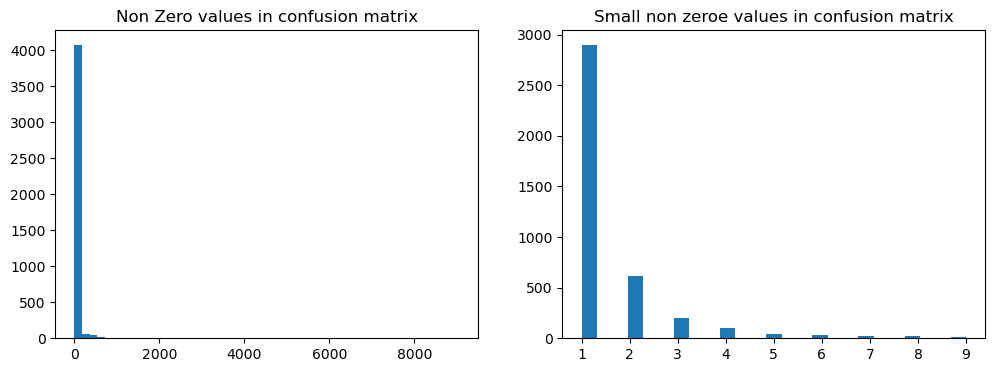

In [ ]:
non_zeroes = confmat.numpy().flatten()[confmat.numpy().flatten() > 0]
small_vals = confmat.numpy().flatten()[(confmat.numpy().flatten() > 0) & (confmat.numpy().flatten() < 10)]
np.median(non_zeroes), np.percentile(non_zeroes, 80)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(non_zeroes, bins=50)
ax1.set_title('Non Zero values in confusion matrix')
ax2.hist(small_vals, bins=25)
ax2.set_title('Small non zeroe values in confusion matrix')
plt.show()

In [ ]:
confmat.numpy().max(), np.median(confmat.numpy()), np.percentile(confmat.numpy(), 99)

(9046, 0.0, 6.0)

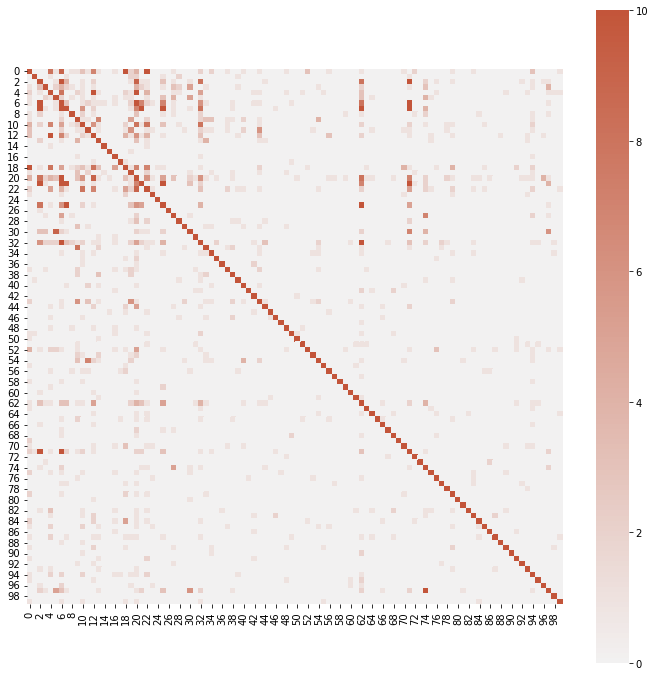

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(confmat[:100,:100], center=0, vmax=10, cmap=cmap, square=True, ax=ax);

In [ ]:
val_text_ds = tf.data.TextLineDataset(get_file(val_at_dir)).batch(1024)
val_ds = val_text_ds.map(strings_to_tensors)

In [ ]:
prob_preds = model.predict(val_ds)

In [ ]:
prob_preds[0].shape, prob_preds[1].shape

((199992, 187), (199992, 10))

In [ ]:
class_preds = np.argmax(prob_preds[0], axis=1)

In [ ]:
class_labels_ohe = None
for xb, (yb, _) in val_ds:
    class_labels_ohe = tf.concat([class_labels_ohe, yb], axis=0) if class_labels_ohe is not None else yb
# print(class_labels_ohe.shape)
class_labels = np.argmax(class_labels_ohe, axis=1)

In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(class_labels, class_preds).numpy()

0.9468229

**Confusion Matrix**
The matrix **columns** represent the prediction labels and the **rows** represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task.

In [ ]:
confmat = tf.math.confusion_matrix(class_labels, class_preds)
confmat.shape

TensorShape([187, 187])

In [ ]:
confmat[:10,:10]

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5983,    0,    2,    0,   11,    2,   14,    0,    1,    2],
       [   0,  857,    1,    1,    0,    0,    1,    0,    0,    0],
       [   0,    2, 7393,    3,    3,    3,   35,   14,    1,    1],
       [   0,    0,    4, 1366,    3,    2,    6,    0,    2,    0],
       [   6,    1,    4,    3, 5531,    2,   19,    3,    1,    1],
       [   0,    0,    6,    7,    0, 1350,    3,    5,    3,    1],
       [   7,    1,   27,    4,    7,    7, 9046,   19,    1,    1],
       [   0,    0,   38,    1,    1,    0,   29, 5597,    0,    1],
       [   1,    0,    0,    3,    3,    5,    2,    0, 1242,    0],
       [   0,    0,    2,    0,    1,    0,    3,    1,    0, 3337]],
      dtype=int32)>

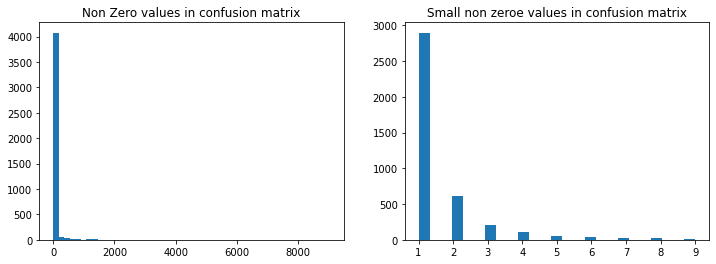

In [ ]:
non_zeroes = confmat.numpy().flatten()[confmat.numpy().flatten() > 0]
small_vals = confmat.numpy().flatten()[(confmat.numpy().flatten() > 0) & (confmat.numpy().flatten() < 10)]
np.median(non_zeroes), np.percentile(non_zeroes, 80)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(non_zeroes, bins=50)
ax1.set_title('Non Zero values in confusion matrix')
ax2.hist(small_vals, bins=25)
ax2.set_title('Small non zeroe values in confusion matrix')
plt.show()

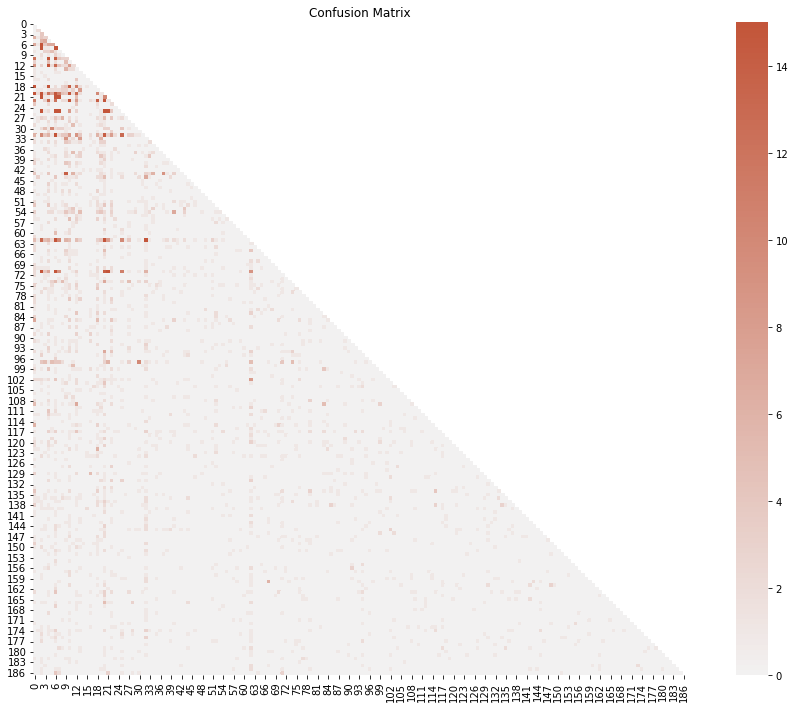

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(18,12))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_title('Confusion Matrix')
mask = np.zeros_like(confmat)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(confmat, mask=mask, center=0, vmax=15, cmap=cmap, square=True, ax=ax);

**Precision:** Precision answers the following question: 
- Given one class, what is the proportion of predictions for that class which is correctly predicted?
- Intuition: given one prediction, how confident can we be that it is correct, precise
- Looking at the confusion matrix, we consider it column by columns

**Recall:** Recall answers a different question: 
- Given one class, what is the proportion of among all actual samples in  that class that is correctly classified?
- Intuition: given one class, how confident that we will retrieve all the samples in that class (recall)



In [ ]:
true_nbr_samples_per_virus = confmat.numpy().sum(axis=1)
pred_nbr_samples_per_virus = confmat.numpy().sum(axis=0)
print(true_nbr_samples_per_virus)
print(pred_nbr_samples_per_virus)

[7060  887 7629 1435 6174 1449 9408 5970 1304 3427 4805 2056 6191 3101
  184  201  713  302 7600 3876 8926 5889 4909  711  192 5891  166 1319
  872  704 1389  320 5514 1290 1229  462  208 1232  938 1357 1251  485
  191 2441 2236  202  441  208  511  471  223  718 1483  584 1885  288
  659  261  209  337 1959  189 6624  479  491  537  506  408  454  218
  723 5643  456  274 1417  467  696  275  286  756  179  170  483  704
  630  724  265  616  196  452  118  587  281  438 1113  430  307 1445
  283  783  175  273 2178  415  426  212  193  334  721  733  355  487
  442  240  253  753  192 1154  431  523  723  581  616  277  356  250
  250  442  111  712  403  337  260  229  724  417  935  417  774  437
  128  284  279  418  423  435  436  282  309  289  287  347  294   90
  145  221  458  305  282  296  436  281  314  781  286  283  431  148
  152  281   41  268  257  292  852  486  307  455  126  318  329  325
  290   83  306  290  389]
[6928  884 7679 1444 6155 1427 9512 5822 1318 3462

In [ ]:
test_prec = np.diagonal(confmat.numpy()) / pred_nbr_samples_per_virus
print(test_prec)

[0.863597   0.96945701 0.96275557 0.94598338 0.89861901 0.94604064
 0.95100925 0.96135349 0.94233687 0.9638937  0.95212435 0.9667319
 0.89373905 0.96746411 0.97660819 0.95522388 0.9337931  0.94078947
 0.86157793 0.97375193 0.952189   0.96558808 0.9550152  0.95810056
 0.94923858 0.9448345  0.98113208 0.93815988 0.97775176 0.97671033
 0.95325055 0.94099379 0.95243263 0.96342412 0.96068796 0.93347639
 0.94660194 0.96272285 0.96367521 0.979442   0.95583596 0.98504274
 0.94240838 0.96244898 0.97837838 0.95049505 0.96495327 0.98979592
 0.97363083 0.96095445 0.98604651 0.95774648 0.96062458 0.96678322
 0.97214783 0.95104895 0.95975232 0.94921875 0.94736842 0.95870206
 0.99028133 0.95238095 0.95086105 0.9665272  0.95876289 0.96850394
 0.956778   0.92417062 0.95991091 0.93693694 0.95810056 0.95547765
 0.95982143 0.97378277 0.93219178 0.95196507 0.9321075  0.94318182
 0.95340502 0.94278283 0.98795181 0.96385542 0.9640592  0.94397759
 0.96172249 0.96511628 0.96153846 0.96381579 0.93846154 0.96196

In [ ]:
test_recall = np.diagonal(confmat.numpy()) / true_nbr_samples_per_virus
print(test_recall)

[0.84745042 0.96617813 0.96906541 0.95191638 0.89585358 0.93167702
 0.96152211 0.93752094 0.95245399 0.97373796 0.95608741 0.96108949
 0.90615409 0.97807159 0.9076087  0.95522388 0.94950912 0.94701987
 0.88368421 0.97626419 0.95272238 0.95771778 0.96007333 0.96483826
 0.97395833 0.95942964 0.93975904 0.94313874 0.95756881 0.953125
 0.93952484 0.946875   0.95502358 0.95968992 0.9544345  0.94155844
 0.9375     0.96428571 0.96162047 0.98305085 0.96882494 0.95051546
 0.94240838 0.96599754 0.97137746 0.95049505 0.93650794 0.93269231
 0.93933464 0.94055202 0.95067265 0.94707521 0.954147   0.94691781
 0.96286472 0.94444444 0.94081942 0.93103448 0.94736842 0.96439169
 0.98825932 0.95238095 0.96693841 0.96450939 0.94704684 0.91620112
 0.96245059 0.95588235 0.94933921 0.95412844 0.94882434 0.96597554
 0.94298246 0.94890511 0.96047989 0.93361884 0.94683908 0.90545455
 0.93006993 0.95899471 0.91620112 0.94117647 0.94409938 0.95738636
 0.95714286 0.91712707 0.94339623 0.9512987  0.93367347 0.951327

In [ ]:
n = 50
smallest_prec = np.argsort(test_prec)[0:n]
smallest_recall = np.argsort(test_recall)[0:n]
display(smallest_prec)
display(smallest_recall)
smallest_prec_and_recall = np.array(list(set(smallest_prec).intersection(set(smallest_recall))))
smallest_prec_and_recall

array([ 18,   0,  12,   4, 145,  67, 130,  76,  74, 173,  35,  16,  94,
        92, 129,  69,  91, 166,  27,  88, 101, 128, 120,  17,  31, 114,
         8,  42,  79,  77, 127,  83,  25, 118,   3,   5,  36, 122,  58,
       135, 176, 182, 105, 121, 100,  57,  24, 180, 126, 139])

array([  0,  18,   4,  77,  12,  14,  80,  65,  85, 124, 147, 145, 161,
        92, 140,  78, 179, 151,  57, 123,   5, 159,  47,  75,  88, 109,
        46, 178,  36, 116,   7, 137,  91,  48,  30, 183,  26,  98,  49,
        93, 131,  90, 168,  56,  81,  99, 185,  35, 166,  42])

array([  0,  35,   4,   5,  36, 166,  42,  12,  77, 145,  18,  88,  57,
        91,  92])

In [ ]:
p2virus_class_mapping = Path('/content/gdrive/MyDrive/Metagenonics/CNN_Virus_data/map_standard')
with open(p2virus_class_mapping, 'r') as fp:
    label2virus = []
    virus2label = {}
    while True:
        line = fp.readline()[:-1]
        if line == '': break
        virus, label = line.split('\t')
        label2virus.append(virus)
        virus2label[virus] = label
label2virus=np.array(label2virus)

In [ ]:
label2virus[smallest_prec_and_recall].tolist()

['Variola_virus',
 'Sandfly_fever_Naples_phlebovirus',
 'Human_betaherpesvirus_6B',
 'Human_mastadenovirus_B',
 'Human_polyomavirus_13',
 'Mayaro_virus',
 'Human_polyomavirus_5',
 'Human_betaherpesvirus_6A',
 'Enterovirus_E',
 'Eastern_equine_encephalitis_virus',
 'Monkeypox_virus',
 'Human_polyomavirus_6',
 'Cosavirus_E',
 'Mumps_rubulavirus',
 'Enterovirus_F']

In [ ]:
label2virus[smallest_prec].tolist()

['Monkeypox_virus',
 'Variola_virus',
 'Human_betaherpesvirus_6A',
 'Human_betaherpesvirus_6B',
 'Eastern_equine_encephalitis_virus',
 'Louping_ill_virus',
 'Zika_virus',
 'Crimean-Congo_hemorrhagic_fever_orthonairovirus',
 'Human_mastadenovirus_G',
 'Cosavirus_A',
 'Sandfly_fever_Naples_phlebovirus',
 'Hendra_henipavirus',
 'Middle_East_respiratory_syndrome-related_coronavirus',
 'Enterovirus_F',
 'Nipah_henipavirus',
 'Human_polyomavirus_8',
 'Mumps_rubulavirus',
 'Mayaro_virus',
 'Human_mastadenovirus_F',
 'Human_polyomavirus_6',
 'Parechovirus_B',
 'Mamastrovirus_5',
 'Reston_ebolavirus',
 'Human_immunodeficiency_virus_1',
 'Mupapillomavirus_1',
 'Cosavirus_B',
 'Human_mastadenovirus_A',
 'Human_polyomavirus_5',
 'Rotavirus_B',
 'Enterovirus_E',
 'Chandipura_vesiculovirus',
 'Bundibugyo_ebolavirus',
 'Human_alphaherpesvirus_1',
 'Yellow_fever_virus',
 'Human_mastadenovirus_C',
 'Human_mastadenovirus_B',
 'Human_polyomavirus_13',
 'Human_respirovirus_1',
 'Primate_erythroparvovirus_

In [ ]:
label2virus[smallest_recall].tolist()

['Variola_virus',
 'Monkeypox_virus',
 'Human_betaherpesvirus_6B',
 'Enterovirus_E',
 'Human_betaherpesvirus_6A',
 'Human_polyomavirus_12',
 'Human_polyomavirus_11',
 'Influenza_A_virus',
 'Rotavirus_H',
 'Lymphocytic_choriomeningitis_mammarenavirus',
 'Enterovirus_B',
 'Eastern_equine_encephalitis_virus',
 'Enterovirus_J',
 'Enterovirus_F',
 'Mamastrovirus_11',
 'Enterovirus_C',
 'Sapporo_virus',
 'Rosavirus_A',
 'Cosavirus_E',
 'Parechovirus_A',
 'Human_mastadenovirus_B',
 'Norwalk_virus',
 'Human_polyomavirus_3',
 'Hantaan_orthohantavirus',
 'Human_polyomavirus_6',
 'Tai_Forest_ebolavirus',
 'Dengue_virus',
 'Mamastrovirus_14',
 'Human_polyomavirus_13',
 'Primate_erythroparvovirus_4',
 'Human_alphaherpesvirus_2',
 'Japanese_encephalitis_virus',
 'Mumps_rubulavirus',
 'Puumala_orthohantavirus',
 'Human_mastadenovirus_E',
 'Mamastrovirus_17',
 'Mamastrovirus_15',
 'Mupapillomavirus_2',
 'Mokola_lyssavirus',
 'Machupo_mammarenavirus',
 'Primate_T-lymphotropic_virus_3',
 'Mamastrovirus_

In [ ]:
smallest_df = pd.DataFrame(
    data=confmat.numpy()[smallest_prec_and_recall, :][:, smallest_prec_and_recall], 
    index=label2virus[smallest_prec_and_recall], 
    columns=label2virus[smallest_prec_and_recall], 
)

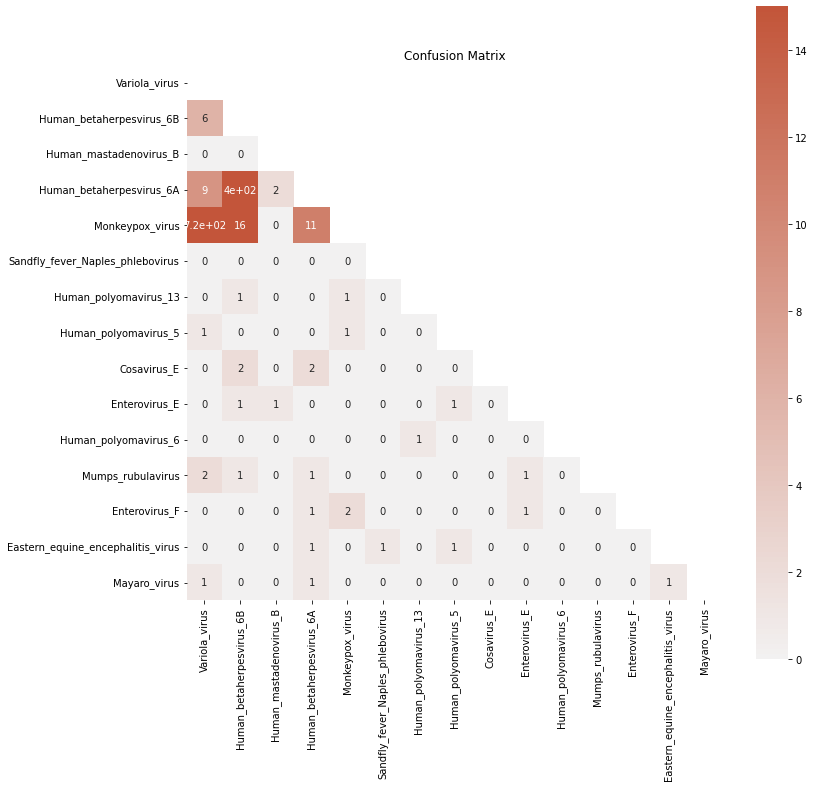

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_title('Confusion Matrix')
mask = np.zeros_like(smallest_df.values)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(smallest_df, mask=mask, center=0, vmax=15, cmap=cmap, square=True, annot=True, ax=ax);

# New Section